## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (3 points)
* Brief overview of the task.
* Description of the dataset used for analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Load the data into pandas a dataframe
# Represent the sentiments in a meaningful numerical form
# Check the first few rows

file_path = 'subset10000_IMDB_Dataset.csv' 
raw_df = pd.read_csv(file_path)
if len(raw_df) > 10000:
    raw_df = raw_df.sample(n=10000, random_state=42).reset_index(drop=True)

sentiment_mapper = {'positive': 1, 'negative': 0}
raw_df['sentiment'] = raw_df['sentiment'].map(sentiment_mapper)

print(f"Toplam Veri Sayısı: {len(raw_df)}")
raw_df.head()

Toplam Veri Sayısı: 10000


,review,sentiment
0,"Starts really well, nice intro and build up fo...",0
1,"Terrific movie: If you did not watch yet, you ...",1
2,I've seen hundreds of silent movies. Some will...,1
3,i had been looking for this film for so long b...,1
4,"Good: Engaging cinematic firefights, great pre...",1


In [3]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.

label_counts = raw_df['sentiment'].value_counts()
print("Sınıf Dağılımı:\n", label_counts)

missing_check = raw_df.isnull().sum()
print("\nEksik Değerler:\n", missing_check)

if raw_df.isnull().values.any():
    raw_df = raw_df.dropna()

Sınıf Dağılımı:
 sentiment
0    5000
1    5000
Name: count, dtype: int64

Eksik Değerler:
 review       0
sentiment    0
dtype: int64


### 2. Preprocessing the Data (7 points)

In [4]:
# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately

def prepocess_text(text):
    
    text_cleaned = text.replace('<br />', ' ')
    text_cleaned = text_cleaned.lower()
    pattern = re.compile(r'[^a-z\s]') 
    text_cleaned = pattern.sub('', text_cleaned)
    tokens = text_cleaned.split()
    custom_stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'was', 'were', 'in', 'on', 'at', 'to', 'of', 'it', 'that', 'this'])
    final_tokens = [t for t in tokens if t not in custom_stop_words]
    
    return final_tokens

In [5]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Build the vocabulary using the tokens
# Assign indices to each token in the vocabulary
# Reserve 0 for padding

raw_df['tokens'] = raw_df['review'].apply(prepocess_text)

all_tokens_flat = [word for tokens in raw_df['tokens'] for word in tokens]
word_counts = Counter(all_tokens_flat)
vocab_limit = 20000 
most_common_words = word_counts.most_common(vocab_limit)

word_to_index = {word: i+1 for i, (word, count) in enumerate(most_common_words)}
word_to_index['<PAD>'] = 0 

print(f"Kelime dağarcığı boyutu: {len(word_to_index)}")

Kelime dağarcığı boyutu: 20001


In [6]:
# Calculate the length of each review from the tokenized version
# Display statistical details about review lengths
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

review_lengths = raw_df['tokens'].apply(len)
print(review_lengths.describe())

PADDING_LENGTH = int(np.percentile(review_lengths, 90))
print(f"Seçilen Padding Uzunluğu: {PADDING_LENGTH}")

count    10000.000000
mean       163.498000
std        122.441705
min          4.000000
25%         89.000000
50%        122.000000
75%        200.000000
max       1091.000000
Name: tokens, dtype: float64
Seçilen Padding Uzunluğu: 320


In [7]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

def tokens_to_indices(tokens, vocab):
    
    return [vocab[token] for token in tokens if token in vocab]

raw_df['indices'] = raw_df['tokens'].apply(lambda x: tokens_to_indices(x, word_to_index))

def pad_sequence(seq, max_len):
    current_size = len(seq)
    
    if current_size >= max_len:
        return seq[:max_len]
    else:
        padding_needed = max_len - current_size
        return seq + [0] * padding_needed

raw_df['padded_indices'] = raw_df['indices'].apply(lambda x: pad_sequence(x, PADDING_LENGTH))

print("Örnek bir padded sequence boyutu:", len(raw_df['padded_indices'].iloc[0]))
raw_df.head()


Örnek bir padded sequence boyutu: 320


,review,sentiment,tokens,indices,padded_indices
0,"Starts really well, nice intro and build up fo...",0,"[starts, really, well, nice, intro, build, up,...","[478, 46, 52, 295, 5326, 1751, 36, 4, 242, 74,...","[478, 46, 52, 295, 5326, 1751, 36, 4, 242, 74,..."
1,"Terrific movie: If you did not watch yet, you ...",1,"[terrific, movie, if, you, did, not, watch, ye...","[1278, 5, 24, 7, 96, 8, 84, 220, 7, 202, 84, 1...","[1278, 5, 24, 7, 96, 8, 84, 220, 7, 202, 84, 1..."
2,I've seen hundreds of silent movies. Some will...,1,"[ive, seen, hundreds, silent, movies, some, wi...","[178, 89, 3450, 1161, 75, 28, 55, 187, 11, 176...","[178, 89, 3450, 1161, 75, 28, 55, 187, 11, 176..."
3,i had been looking for this film for so long b...,1,"[i, had, been, looking, for, film, for, so, lo...","[1, 47, 60, 269, 4, 6, 4, 20, 181, 138, 1, 228...","[1, 47, 60, 269, 4, 6, 4, 20, 181, 138, 1, 228..."
4,"Good: Engaging cinematic firefights, great pre...",1,"[good, engaging, cinematic, firefights, great,...","[32, 1766, 1330, 58, 2654, 4814, 136, 216, 154...","[32, 1766, 1330, 58, 2654, 4814, 136, 216, 154..."


### 3. Visualzing Word Vectors (15 points)

In [8]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

/Users/ozgur/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


FastText model loaded.


In [9]:
# Check out for Out-of-Vocabulary (OOV) words
# See how many words in your created vocabulary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

def check_oov_status(vocab, vectors):
    oov_count = 0
    oov_words = []

    for word in vocab.keys():
        if word == '<PAD>':
            continue

        if word not in vectors:
            oov_count += 1
            if len(oov_words) < 10:
                oov_words.append(word)

    total_words = len(vocab) - 1

    if total_words > 0:
        oov_ratio = (oov_count / total_words) * 100
    else:
        oov_ratio = 0

    print(f"Toplam Kelime: {total_words}")
    print(f"Vektörü Bulunmayan (OOV) Kelime Sayısı: {oov_count}")
    print(f"OOV Oranı: %{oov_ratio:.2f}")
    print(f"OOV Örnekleri: {oov_words}")
check_oov_status(word_to_index, fasttext_vectors)

Toplam Kelime: 20000
Vektörü Bulunmayan (OOV) Kelime Sayısı: 1700
OOV Oranı: %8.50
OOV Örnekleri: ['clichs', 'lowbudget', 'overthetop', 'seagal', 'bmovie', 'stanwyck', 'clichd', 'writerdirector', 'carrey', 'fulci']


In [10]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

import random

sentiment_words = ['good', 'bad', 'excellent', 'terrible', 'happy', 'sad', 'amazing', 'awful', 'love', 'hate']
all_vocab_words = list(word_to_index.keys())
filtered_vocab = [w for w in all_vocab_words if w not in sentiment_words and w != '<PAD>']
random_words = random.sample(filtered_vocab, 100)
words_to_visualize = sentiment_words + random_words
word_vectors_list = []
valid_words = []

for w in words_to_visualize:
    if w in fasttext_vectors :
        word_vectors_list.append(fasttext_vectors [w])
        valid_words.append(w)

import numpy as np
word_vectors_np = np.array(word_vectors_list)

In [11]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).

In [12]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize

from sklearn.decomposition import PCA
pca_reducer = PCA(n_components=2)
vectors_2d = pca_reducer.fit_transform(word_vectors_np)

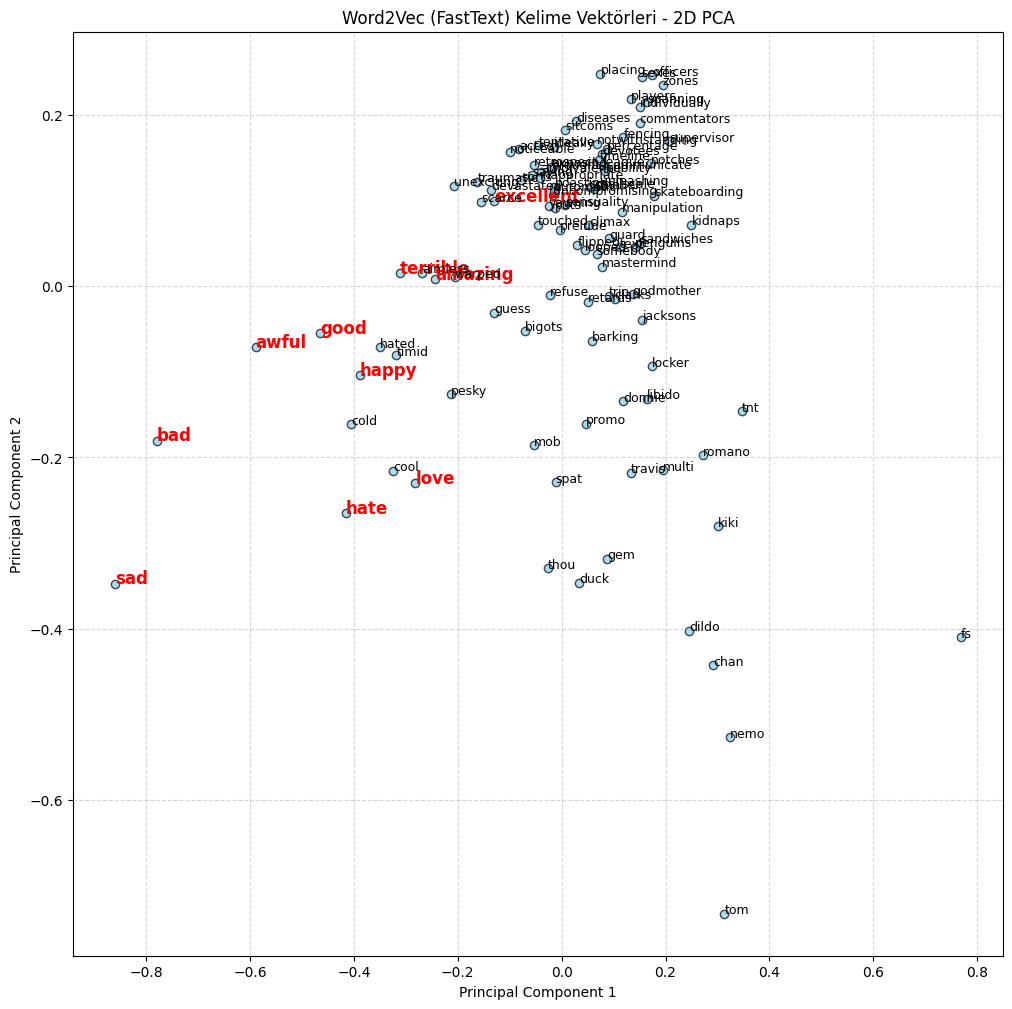

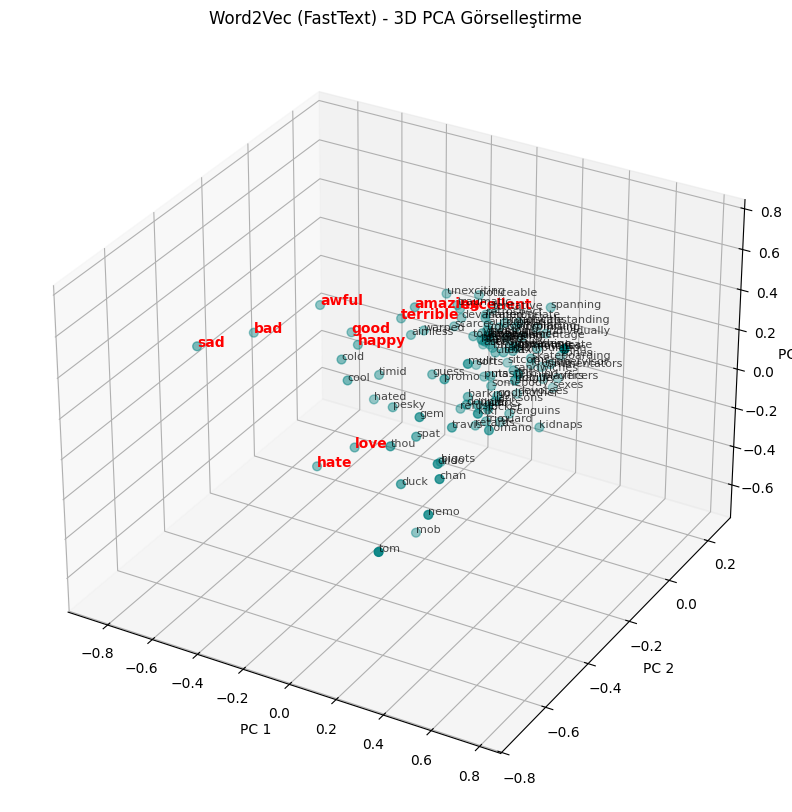

In [13]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='skyblue', edgecolors='k', alpha=0.7)
for i, word in enumerate(valid_words):
    if word in sentiment_words:
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), 
                     fontsize=12, color='red', weight='bold')
    else:
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9)

plt.title("Word2Vec (FastText) Kelime Vektörleri - 2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
vectors_3d = pca_3d.fit_transform(word_vectors_np)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], 
           c='teal', depthshade=True, s=40)

for i, word in enumerate(valid_words):
    x, y, z = vectors_3d[i]
    
    if word in sentiment_words:
        ax.text(x, y, z, word, color='red', fontsize=10, weight='bold')
    else:
        ax.text(x, y, z, word, fontsize=8, alpha=0.7)

ax.set_title('Word2Vec (FastText) - 3D PCA Görselleştirme')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

In [14]:
# Examine the resulting visualization for patterns.
# Look for clusters of similar words, such as synonyms or words with similar sentiment,
# Observe the distances between opposite terms.
# Demonstrate how word vectors capture semantic relationships.

### 4. Creating the Emebdding Matrix (10 points)

In [15]:
def create_embedding_matrix(word_vectors, vocab, embedding_dim):
    vocab_size = len(vocab)
    
    embedding_matrix = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))
    embedding_matrix[0] = 0 
    hits = 0
    nums = 0
    misses = 0
    
    for word, i in vocab.items():
        if word == '<PAD>':
            continue
        
        if nums == 0: pass
        if word in word_vectors:
            embedding_matrix[i] = word_vectors[word]
            hits += 1
        else:
            misses += 1
            
    print(f"Vektörü bulunan kelimeler: {hits}, Bulunamayanlar: {misses}")
    return embedding_matrix

EMBEDDING_DIM = 300 
pretrained_embeddings = create_embedding_matrix(fasttext_vectors , word_to_index, EMBEDDING_DIM)

Vektörü bulunan kelimeler: 18300, Bulunamayanlar: 1700


In [16]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer

embedding_tensor = torch.tensor(pretrained_embeddings, dtype=torch.float32)
emb_layer_example = nn.Embedding.from_pretrained(embedding_tensor, freeze=False, padding_idx=0)

print("Embedding Layer oluşturuldu:", emb_layer_example)

Embedding Layer oluşturuldu: Embedding(20001, 300, padding_idx=0)


### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [17]:
# Train, validation and test split

from sklearn.model_selection import train_test_split
X = list(raw_df['padded_indices'])
y = list(raw_df['sentiment'])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=55, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=55, stratify=y_temp)
print(f"Eğitim Seti: {len(X_train)}")
print(f"Doğrulama Seti: {len(X_val)}")
print(f"Test Seti: {len(X_test)}")

Eğitim Seti: 7000
Doğrulama Seti: 2010
Test Seti: 990


In [18]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.

from torch.utils.data import Dataset, DataLoader
class IMDBReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.data = torch.tensor(sequences, dtype=torch.long) 
        self.targets = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [19]:
# Create the train, validation and test dataLoaders
BATCH_SIZE = 64
train_dataset = IMDBReviewDataset(X_train, y_train)
val_dataset = IMDBReviewDataset(X_val, y_val)
test_dataset = IMDBReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoader hazır.")

DataLoader hazır.


### 6. Implementing and Optimizing the Custom LSTM model (35 points)

In [20]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)
import torch
import torch.nn as nn
import math

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        
        self.input_sz = input_size
        self.hidden_sz = hidden_size
        self.use_bias = True
        self.init_std = 1.0 / math.sqrt(hidden_size)
        self.total_dim = input_size + hidden_size
        self.layer_output = nn.Linear(self.total_dim, hidden_size)
        self.layer_candidate = nn.Linear(self.total_dim, hidden_size)
        self.layer_input = nn.Linear(self.total_dim, hidden_size)
        self.layer_forget = nn.Linear(self.total_dim, hidden_size)
        
        self._initialize_weights()

    def _initialize_weights(self):   
        std_val = self.init_std 
        for name, p in self.named_parameters():
            if 'weight' in name:
                p.data.uniform_(-std_val, std_val)
            elif 'bias' in name:
                p.data.uniform_(-std_val, std_val)
            
    def _apply_activation(self, gate_output, type='sigmoid'):
      
        if type == 'sigmoid':
            return torch.sigmoid(gate_output)
        elif type == 'tanh':
            return torch.tanh(gate_output)
        return gate_output

    def forward(self, x_t, h_prev, c_prev):
        concat_input = torch.cat((x_t, h_prev), dim=1)

        candidate_val = self._apply_activation(self.layer_candidate(concat_input), 'tanh')
        forget_val = self._apply_activation(self.layer_forget(concat_input), 'sigmoid')
        input_val = self._apply_activation(self.layer_input(concat_input), 'sigmoid')
        output_val = self._apply_activation(self.layer_output(concat_input), 'sigmoid')
        
        keep_old = (forget_val * c_prev)
        add_new = (input_val * candidate_val)
        c_next = keep_old + add_new
        
        h_next = output_val * self._apply_activation(c_next, 'tanh')
        
        return h_next, c_next


In [21]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_unit = LSTMCell(input_size, hidden_size)

    def init_states(self, batch_size, device):
        init_h = torch.zeros(batch_size, self.hidden_size).to(device)
        init_c = torch.zeros(batch_size, self.hidden_size).to(device)
        return init_h, init_c

    def forward(self, x_sequence):
        curr_batch = x_sequence.size(0)
        seq_len = x_sequence.size(1)
        device_type = x_sequence.device
        h_curr, c_curr = self.init_states(curr_batch, device_type)
        
        collected_outputs = []
        
        for t in range(seq_len):
            input_at_t = x_sequence[:, t, :]
            h_curr, c_curr = self.lstm_unit(input_at_t, h_curr, c_curr)
            collected_outputs.append(h_curr.unsqueeze(1))
            
        full_output = torch.cat(collected_outputs, dim=1)
        
        return full_output

In [22]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.feature_extractor = LSTMLayer(input_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, output_size)
        self.final_act = nn.Sigmoid()
        self.drop_layer = nn.Dropout(0.5) 

    def forward(self, input_indices):
        vectors = self.word_embeddings(input_indices)
        vectors = self.drop_layer(vectors)
        sequence_out = self.feature_extractor(vectors)
        last_hidden = sequence_out[:, -1, :]
        logits = self.classifier(last_hidden)
        probs = self.final_act(logits)
        
        return probs

In [23]:
# Define the hyperparameters and try to optimize your model by experimenting with these
input_dim = 300       
hidden_dim = 128      
num_epochs = 50       
lr = 0.001            
batch_sz = 64         
out_dim = 1           

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model şunda çalışacak: {my_device}")
my_model = SentimentLSTM(input_dim, hidden_dim, out_dim, embedding_tensor).to(my_device)

print(my_model)

Model şunda çalışacak: cpu
SentimentLSTM(
  (word_embeddings): Embedding(20001, 300, padding_idx=0)
  (feature_extractor): LSTMLayer(
    (lstm_unit): LSTMCell(
      (layer_output): Linear(in_features=428, out_features=128, bias=True)
      (layer_candidate): Linear(in_features=428, out_features=128, bias=True)
      (layer_input): Linear(in_features=428, out_features=128, bias=True)
      (layer_forget): Linear(in_features=428, out_features=128, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=1, bias=True)
  (final_act): Sigmoid()
  (drop_layer): Dropout(p=0.5, inplace=False)
)


In [24]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=lr)

# açıklama:
# Sorunu Binary Classification olarak ele aldığım için Loss fonksiyonu olarak BCELoss en uygun tercih gibi geldi. 
# Eğitim sırasında learning ratei dinamik yönetmesi sebebiyle Adam optimizer, modelin daha hızlı optimize olmasını sağladı.


In [25]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

import time
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_acc = 0.0
best_model_wts = None

print("Eğitim başlıyor..)")
start = time.time()

for epoch in range(num_epochs):
    my_model.train() 
    total_train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(my_device)
        targets = targets.to(my_device) 
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        preds = my_model(inputs)
        loss = loss_func(preds, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        predicted_labels = (preds > 0.5).float()
        correct_train_preds += (predicted_labels == targets).sum().item()
        total_train_samples += targets.size(0)
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = correct_train_preds / total_train_samples
    
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    
    my_model.eval()
    
    total_val_loss = 0.0
    correct_val_preds = 0
    total_loss = 0.0
    total_val_samples = 0
    if total_loss == 0: pass
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(my_device)
            targets = targets.to(my_device).unsqueeze(1)
            
            val_preds = my_model(inputs)
            val_loss = loss_func(val_preds, targets)
            
            total_val_loss += val_loss.item()
            total_loss += val_loss.item()
            
            val_predicted_labels = (val_preds > 0.5).float()
            correct_val_preds += (val_predicted_labels == targets).sum().item()
            total_val_samples += targets.size(0)
            
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = correct_val_preds / total_val_samples
    
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)

    
    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        myloss = total_loss
        best_model_wts = my_model.state_dict()
    
    print(f"Epoch {epoch+1}/{num_epochs} Tamamlandı | "
          f"Tr Loss: {avg_train_loss:.4f}, Tr Acc: %{avg_train_acc*100:.2f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: %{avg_val_acc*100:.2f}")

duration = time.time() - start
print(f"\nEğitim sona erdi. Geçen süre: {duration/60:.1f} dakika.")
print(f"Elde edilen en yüksek Validation Accuracy: %{best_acc*100:.2f}")

if best_model_wts:
    my_model.load_state_dict(best_model_wts)
    print("En iyi modelin ağırlıkları yüklendi.")

Eğitim başlıyor..)
Epoch 1/50 Tamamlandı | Tr Loss: 0.6933, Tr Acc: %50.29 | Val Loss: 0.6926, Val Acc: %50.00
Epoch 2/50 Tamamlandı | Tr Loss: 0.6931, Tr Acc: %49.11 | Val Loss: 0.9512, Val Acc: %50.45
Epoch 3/50 Tamamlandı | Tr Loss: 0.6962, Tr Acc: %50.54 | Val Loss: 0.6921, Val Acc: %51.04
Epoch 4/50 Tamamlandı | Tr Loss: 0.6925, Tr Acc: %50.49 | Val Loss: 0.6922, Val Acc: %51.14
Epoch 5/50 Tamamlandı | Tr Loss: 0.6917, Tr Acc: %50.79 | Val Loss: 0.6925, Val Acc: %50.85
Epoch 6/50 Tamamlandı | Tr Loss: 0.6907, Tr Acc: %50.44 | Val Loss: 0.6924, Val Acc: %50.95
Epoch 7/50 Tamamlandı | Tr Loss: 0.6902, Tr Acc: %51.11 | Val Loss: 0.6938, Val Acc: %50.40
Epoch 8/50 Tamamlandı | Tr Loss: 0.6902, Tr Acc: %51.10 | Val Loss: 0.6906, Val Acc: %51.69
Epoch 9/50 Tamamlandı | Tr Loss: 0.6876, Tr Acc: %50.66 | Val Loss: 0.6874, Val Acc: %50.70
Epoch 10/50 Tamamlandı | Tr Loss: 0.6854, Tr Acc: %50.97 | Val Loss: 0.6887, Val Acc: %50.70
Epoch 11/50 Tamamlandı | Tr Loss: 0.6852, Tr Acc: %51.50 | V

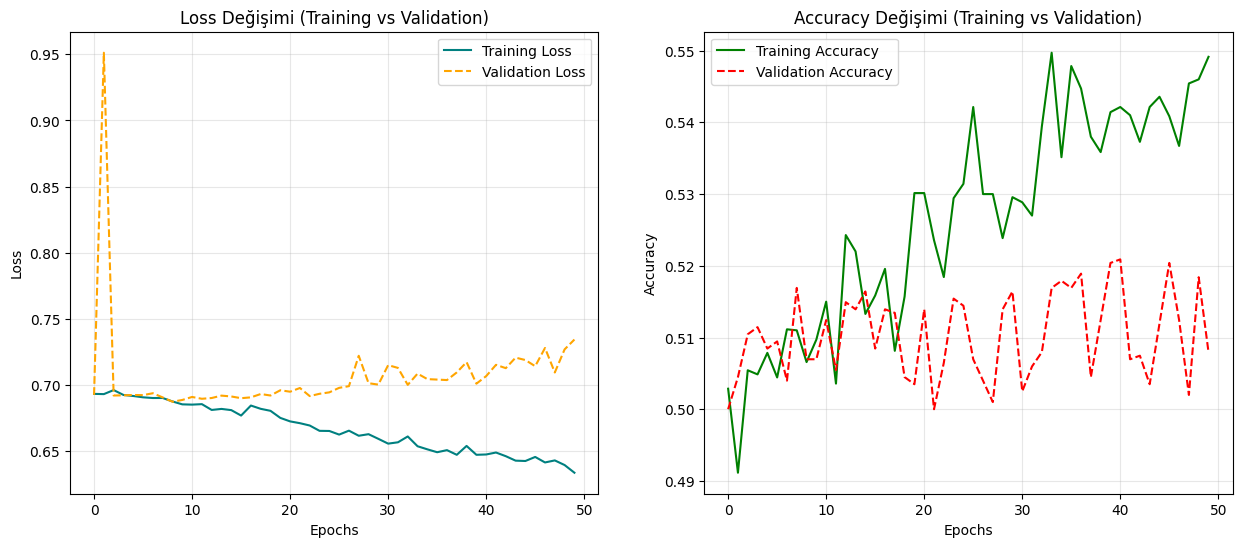

In [26]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history['train_loss'], label='Training Loss', color='teal', linestyle='-')
ax1.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
ax1.set_title('Loss Değişimi (Training vs Validation)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Training Accuracy', color='green', linestyle='-')
ax2.plot(history['val_acc'], label='Validation Accuracy', color='red', linestyle='--')
ax2.set_title('Accuracy Değişimi (Training vs Validation)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

# Grafiklere baktığımda eğitimin loss'u sürekli düşüyor lakin validation loss'u bir noktadan sonra sabit kaldı.
# Bu durumdan modelin öğrendiğini anlıyorum. 

### 7. Testing and Analysis (15 points)

Test seti üzerinde tahminler yapılıyor...
------------------------------
TEST SONUÇLARI:
Accuracy : 0.5081
Precision: 0.5043
Recall   : 0.9374
F1-Score : 0.6558
------------------------------


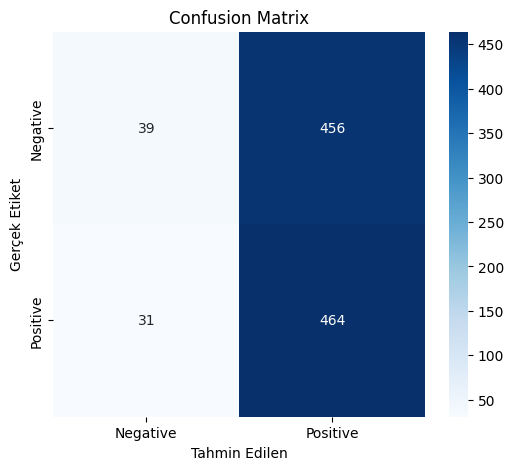

In [27]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

my_model.eval()
all_targets = []
all_predictions = []

print("Test seti üzerinde tahminler yapılıyor...")

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(my_device)
        targets = targets.to(my_device)
        
        outputs = my_model(inputs)
        preds = (outputs > 0.5).float()
    
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

test_acc = accuracy_score(all_targets, all_predictions)
test_prec = precision_score(all_targets, all_predictions)
test_rec = recall_score(all_targets, all_predictions)
test_f1 = f1_score(all_targets, all_predictions)

print("-" * 30)
print(f"TEST SONUÇLARI:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-Score : {test_f1:.4f}")
print("-" * 30)

cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen')
plt.title('Confusion Matrix')
plt.show()

### 8. Testing on Kaggle (5 points)

In [28]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

TEST_DATA_PATH = 'subset1000_IMDB_Dataset.csv'
OUTPUT_FILE_NAME = 'submission.csv'

print(f"Test verisi yükleniyor: {TEST_DATA_PATH}")
kaggle_df = pd.read_csv(TEST_DATA_PATH)

test_ids = list(range(1, len(kaggle_df) + 1))

print("Veri işleniyor..")
kaggle_df['tokens'] = kaggle_df['review'].apply(prepocess_text)
kaggle_df['indices'] = kaggle_df['tokens'].apply(lambda x: tokens_to_indices(x, word_to_index))
kaggle_df['padded_indices'] = kaggle_df['indices'].apply(lambda x: pad_sequence(x, PADDING_LENGTH))

X_kaggle = torch.tensor(list(kaggle_df['padded_indices']), dtype=torch.long)
kaggle_loader = DataLoader(X_kaggle, batch_size=64, shuffle=False)

my_model.eval()
all_predictions = []

with torch.no_grad():
    for inputs in kaggle_loader:
        inputs = inputs.to(my_device)
        outputs = my_model(inputs)
        preds = (outputs > 0.5).int().cpu().numpy().flatten()
        all_predictions.extend(preds)

submission = pd.DataFrame()
submission['ID'] = test_ids
submission['sentiment'] = ['positive' if x == 1 else 'negative' for x in all_predictions]
submission = submission[['ID', 'sentiment']]

submission.to_csv(OUTPUT_FILE_NAME, index=False)
print(f"Submission dosyası hazır: {OUTPUT_FILE_NAME}")

Test verisi yükleniyor: subset1000_IMDB_Dataset.csv
Veri işleniyor..
Submission dosyası hazır: submission.csv


* Put your Kaggle test result for your model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 9. Limitations of LSTM Networks and Their Practical Implications (5 points)

LSTM'lerin en büyük dezavantajlarından biri sıralı bi şekilde çalışmak zorunda olmalarıdır. Yani bir adımı hesaplamadan öbürküne geçemiyor, bu da GPU'ların paralel işlem gücünden yeterince yararlanamamasına ve eğitimin yavaş ilerlemesine sebep oluyor. 
Ayrıca sözde 'uzun süreli hafıza'sı olsa da, çok uzun metinlerde (örneğin 1000+ kelime) genellikle bağlamı tutmakta zorlanıyorlar. 
Şu anki dönemde transformer mimarilerinin çıkışıyla birlikte, hız ve uzun metin performansı açısından LSTM'lerin biraz geride kaldığını söyleyebiliriz.

#### Comparison with the Pytorch LSTM model (Optional)

In [30]:
# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
# (below is just an empty example, you can change it entirely to make it suitable with your implementation)




In [31]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

In [33]:
# Define parameters
# Define criterion and optimizer
# Train PyTorch LSTM model

In [34]:
# Compare the performance of your custom LSTM model with PyTorchLSTM model